<a href="https://colab.research.google.com/github/mehulsharma3795/Credit-Card-Default-Model/blob/master/BenchMark_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Required Libraries

In [1]:
!pip install yfinance

In [8]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import duckdb as ddb
import datetime
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

### Extracting Required Data from Yahoo Finance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def get_ticker_data(yf_symbol, start="2014-01-01", end="2024-03-31"):
  df = pdr.get_data_yahoo(yf_symbol, start=start, end=end)
  return df

In [15]:
selected_eq = [
    'AXISBANK.NS', 'BHARTIARTL.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'ITC.NS', 'LT.NS',
    'RELIANCE.NS', 'SBIN.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS'
]

data = pd.DataFrame(columns = [])

for i, ticker in enumerate(selected_eq):
    temp = get_ticker_data(ticker, start="2014-01-01", end="2024-03-31")
    temp = temp[['Date', ]]
    temp.reset_index(inplace=True)
    print(temp.columns)
    data = pd.merge(data, temp, how = 'outer', on = 'Date')
    print(ticker, data.shape)

[*********************100%%**********************]  1 of 1 completed

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


KeyError: 'Date'

### Data Cleaning and Formatting

We have dropped null values from the dataset

In [ ]:
data['timestamp'] = pd.to_datetime(data.timestamp, format = '%Y-%m-%d')
data.set_index('timestamp', inplace = True)
data.dropna(how = 'all', inplace = True)
data.isnull().sum()

AXISBANK      0
BHARTIARTL    0
HDFCBANK      0
ICICIBANK     0
INFY          0
ITC           0
LT            0
RELIANCE      0
SBIN          0
TATAMOTORS    0
TATASTEEL     0
TCS           0
dtype: int64

In [ ]:
data = data.astype(float)

In [ ]:
data.head()

,AXISBANK,BHARTIARTL,HDFCBANK,ICICIBANK,INFY,ITC,LT,RELIANCE,SBIN,TATAMOTORS,TATASTEEL,TCS
timestamp,,,,,,,,,,,,
2014-01-01,1292.20,337.75,665.15,1097.7,3468.00,322.40,1068.55,888.80,1765.05,374.95,425.9,2153.30
2014-01-02,1272.30,328.70,657.00,1075.6,3480.55,314.95,1036.05,875.00,1742.60,372.35,419.2,2167.00
2014-01-03,1260.90,329.35,663.10,1066.8,3565.15,314.75,1012.05,864.25,1719.65,362.70,412.5,2222.20
2014-01-06,1256.30,329.35,661.70,1040.8,3517.90,315.65,1010.50,854.95,1688.15,366.95,408.3,2239.60
2014-01-07,1234.25,331.70,664.40,1050.0,3457.15,316.70,1019.50,842.10,1661.40,365.10,394.7,2206.15


In [ ]:
# Function to calculate portfolio mean return and variance
def portfolio_stats(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_variance

# Function to generate random portfolios
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_variance = portfolio_stats(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_return
        results[1,i] = portfolio_variance
        results[2,i] = portfolio_return / portfolio_variance
    return results, weights_record

In [ ]:
# Calculate mean returns and covariance matrix
mean_returns = data.pct_change().mean()
cov_matrix = data.pct_change().cov()

In [ ]:
mean_returns, cov_matrix

(AXISBANK      0.000411
 BHARTIARTL    0.000581
 HDFCBANK      0.000550
 ICICIBANK     0.000452
 INFY         -0.000020
 ITC           0.000256
 LT            0.000554
 RELIANCE      0.000653
 SBIN          0.000366
 TATAMOTORS    0.000748
 TATASTEEL     0.000319
 TCS           0.000369
 dtype: float64,
             AXISBANK  BHARTIARTL  HDFCBANK  ICICIBANK      INFY       ITC  \
 AXISBANK    0.000753    0.000195  0.000132   0.000327  0.000090  0.000099   
 BHARTIARTL  0.000195    0.000551  0.000036   0.000198  0.000115  0.000088   
 HDFCBANK    0.000132    0.000036  0.000319   0.000138  0.000056  0.000070   
 ICICIBANK   0.000327    0.000198  0.000138   0.000695  0.000097  0.000087   
 INFY        0.000090    0.000115  0.000056   0.000097  0.000618  0.000050   
 ITC         0.000099    0.000088  0.000070   0.000087  0.000050  0.000313   
 LT          0.000290    0.000294  0.000077   0.000261  0.000131  0.000094   
 RELIANCE    0.000178    0.000195  0.000089   0.000184  0.000100  0.000

In [ ]:
# Generate random portfolios
num_portfolios = 10000
results, weights = generate_random_portfolios(num_portfolios, mean_returns, cov_matrix)

#### Maximum Sharpe Ratio Portfolio

In [ ]:
# Find portfolio with maximum Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights[max_sharpe_idx]

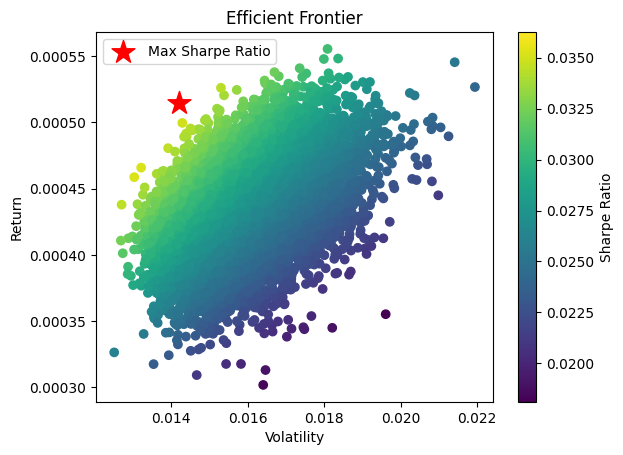

In [ ]:
# Plot the efficient frontier
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(results[1,max_sharpe_idx], results[0,max_sharpe_idx], marker='*', color='r', s=300, label='Max Sharpe Ratio')
plt.legend()
plt.title('Efficient Frontier')
plt.show()

In [ ]:
print("Optimal Weights:", optimal_weights)

Optimal Weights: [0.07530848 0.14288377 0.15145653 0.05568064 0.00197858 0.06581494
 0.14544004 0.18523666 0.02107463 0.02372215 0.00719145 0.12421213]


In [ ]:
print(f"Expected Return of Portfolio : {portfolio_stats(optimal_weights, mean_returns, cov_matrix)[0]*100}")

Expected Return of Portfolio : 0.0514507632840786


In [ ]:
print(f"Expected standard deviation of Portfolio : {portfolio_stats(optimal_weights, mean_returns, cov_matrix)[1]}")

Expected standard deviation of Portfolio : 0.01419299019761162
